COPY FROM t1 FOLDER: change input to have time-dependency and add LSTM model

Search for "FIXME" for tunable parameters

Results summary for data2 (i.e. white noise and inverse):
- PCA: successfully identifies the single common component
- AE-15: MSE 1.3%
- AE-15-3 (non-symmetric): 0.7%
- AE-15-3 (symmetric): 1.1%

All AE give almost perfect replica of output.
The AE-15-3 develop an encoded set of 3 features:
- 2 of which are around 0
- and 1 which is very similar to the single common component

Re-run for sinusoidal data (data1)

## Import libraries

In [1]:
print("load libraries")
import numpy as np
from sklearn.decomposition import PCA
import utils
import keras

# https://stackoverflow.com/a/34306306/4126114
np.random.seed(0)

load libraries


Using TensorFlow backend.


## Generate data

(10000, 2)
X [[ 0.72982333  0.27017667]
 [ 0.54897761  0.45102239]
 [ 0.62569454  0.37430546]
 [ 0.79305005  0.20694995]
 [ 0.74354766  0.25645234]
 [ 0.36633656  0.63366344]
 [ 0.62189575  0.37810425]
 [ 0.47584954  0.52415046]
 [ 0.48223245  0.51776755]
 [ 0.55036207  0.44963793]]


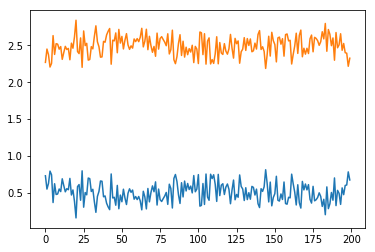

In [2]:
N=int(1e4) # FIXME 1e5

# Try dataset from https://stats.stackexchange.com/questions/190148/autoencoder-pca-tensorflow?rq=1
from sklearn.preprocessing import scale
def data1(n_samples:int=2000):
    n_features=5
    # n_samples, n_features = 2000, 5
    # X = np.random.uniform(0, 1, (n_samples, n_features))
    X = np.zeros((n_samples,n_features))
    
    sigma = 0.1
    xt=np.arange(0,n_samples/10,1/10)
    X[:,0] = .5 + .5*np.sin(1*xt) + np.random.normal(0, sigma, N) +1 # first sine wave
    X[:,1] = .5 + .5*np.sin(2*xt) + np.random.normal(0, sigma, N) +1 # second sine wave
    X[:,2] = 1*np.cos(1*xt) + np.random.normal(0, sigma, N) +1 # lagged version of first sine wave
    X[:,3] = X[:,1]*X[:, 2] # some non-linear relations between lagged and other
    X[:,4] = X[:,1]**2 * X[:, 0]**3 # some non-linear relations between 2 sines
    # auto-encoders need [0-1] range data
    # If PCA input is (mean=0,std=1) and AE is [0-1], MSE is incomparable
    # X = scale(X)
    X = utils.myNorm3(X)
    return X

def data2(n_samples:int=2000):
    n_features=2
    # n_samples, n_features = 2000, 5
    # X = np.random.uniform(0, 1, (n_samples, n_features))
    X = np.zeros((n_samples,n_features), dtype=np.float64)
    sigma = 0.1
    xt=np.arange(0,n_samples/10,1/10)
    X[:,0] = np.random.normal(0, sigma, N) +1 # first sine wave
    X[:,1] = -1*X[:,0]
    X = utils.myNorm3(X)
    return X

def data3(n_samples:int=2000):
    n_features=5
    # n_samples, n_features = 2000, 5
    # X = np.random.uniform(0, 1, (n_samples, n_features))
    X = np.zeros((n_samples,n_features))
    
    sigma = 0.1
    xt=np.arange(0,n_samples/10,1/10)
    X[:,0] = .5 + .5*np.sin(1*xt) + np.random.normal(0, sigma, N) +1 # first sine wave
    X[:,1] = .5 + .5*np.sin(2*xt) + np.random.normal(0, sigma, N) +1 # second sine wave
    X[:,2] = 1*np.cos(1*xt) + np.random.normal(0, sigma, N) +1 # lagged version of first sine wave
    X[:,3] = X[:,1]*X[:, 2] # some non-linear relations between lagged and other
    X[:,4] = X[:,1]**2 * X[:, 0]**3 # some non-linear relations between 2 sines
    # auto-encoders need [0-1] range data
    # If PCA input is (mean=0,std=1) and AE is [0-1], MSE is incomparable
    # X = scale(X)
    X = utils.myNorm3(X)
    return X

X = data1(N)
#X = data2(N)

print(X.shape)
print('X',X[0:10,:])

utils.myPlot(X,2)

## Try PCA

PCA
n_components =  2
err pca =  3.77032632457e-15
Explained variance ratio (cumsum) [ 1.  1.]


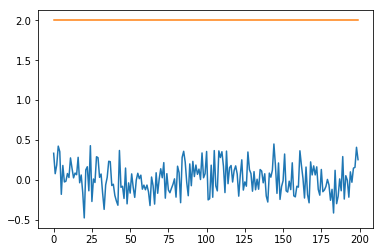

In [3]:
N_epochs = 25
n_c_i = 2#5
print("PCA")
pca = PCA(n_components=n_c_i, random_state=888, svd_solver = 'full')
X_pca = pca.fit_transform(X)
# print("X_pca_0",X_pca_0[0:10,:])
# print("")
# print("Explained variance ratio (cumsum)", np.cumsum(pca.explained_variance_ratio_))
# print("")
print("n_components = ",n_c_i)
utils.pca_err(X, X_pca)
print("Explained variance ratio (cumsum)", np.cumsum(pca.explained_variance_ratio_))
# plot
utils.myPlot(X_pca,2)


## Vanilla AE

autoencoder
n_components =  15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                45        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 32        
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1977: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


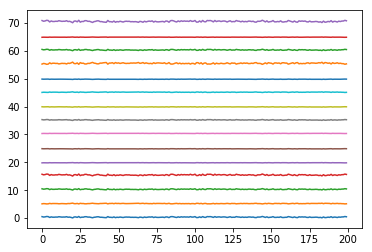

AE1 mse =  0.0133612603166


In [4]:
print("autoencoder")
N_epochs = 200
n_c_i = 15 # [7,10,15,20,25]: # 'mle'
print("n_components = ",n_c_i)

autoencoder, encoder = utils.buildNetwork(X.shape[1], encoding_dim_ae = n_c_i)
autoencoder.summary()
X_rec = utils.ae_fit_encode_plot_mse(X, autoencoder, encoder, N_epochs, verbose=0)
print("AE1 mse = ", utils.mse(X, X_rec))

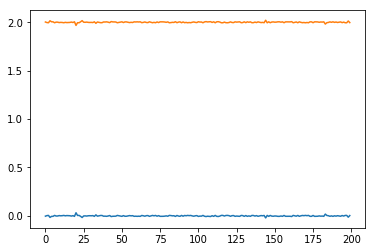

In [5]:
utils.myPlot(X_rec-X,2)

## Deep AE

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                45        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 48        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 8         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1977: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train on 8000 samples, validate on 2000 samples
Epoch 1/200
0s - loss: 0.0172 - val_loss: 0.0164
Epoch 2/200
0s - loss: 0.0156 - val_loss: 0.0153
Epoch 3/200
0s - loss: 0.0145 - val_loss: 0.0140
Epoch 4/200
0s - loss: 0.0133 - val_loss: 0.0128
Epoch 5/200
0s - loss: 0.0120 - val_loss: 0.0114
Epoch 6/200
0s - loss: 0.0106 - val_loss: 0.0101
Epoch 7/200
0s - loss: 0.0094 - val_loss: 0.0090
Epoch 8/200
0s - loss: 0.0083 - val_loss: 0.0079
Epoch 9/200
0s - loss: 0.0073 - val_loss: 0.0070
Epoch 10/200
0s - loss: 0.0064 - val_loss: 0.0060
Epoch 11/200
0s - loss: 0.0055 - val_loss: 0.0051
Epoch 12/200
0s - loss: 0.0045 - val_loss: 0.0041
Epoch 13/200
0s - loss: 0.0035 - val_loss: 0.0031
Epoch 14/200
0s - loss: 0.0026 - val_loss: 0.0022
Epoch 15/200
0s - loss: 0.0018 - val_loss: 0.0015
Epoch 16/200
0s - loss: 0.0011 - val_loss: 8.6491e-04
Epoch 17/200
0s - loss: 6.1640e-04 - val_loss: 4.9686e-04
Epoch 18/200
0s - loss: 3.4336e-04 - val_loss: 3.0567e-04
Epoch 19/200
0s - loss: 2.2270e-04 - val_

0s - loss: 1.8971e-05 - val_loss: 1.7567e-05
Epoch 144/200
0s - loss: 1.9194e-05 - val_loss: 2.0946e-05
Epoch 145/200
0s - loss: 1.8546e-05 - val_loss: 1.5340e-05
Epoch 146/200
0s - loss: 1.9258e-05 - val_loss: 2.8458e-05
Epoch 147/200
0s - loss: 1.9574e-05 - val_loss: 2.4468e-05
Epoch 148/200
0s - loss: 1.8974e-05 - val_loss: 1.7178e-05
Epoch 149/200
0s - loss: 1.8899e-05 - val_loss: 1.8708e-05
Epoch 150/200
0s - loss: 1.9228e-05 - val_loss: 2.0648e-05
Epoch 151/200
0s - loss: 1.9007e-05 - val_loss: 1.8908e-05
Epoch 152/200
0s - loss: 1.9196e-05 - val_loss: 1.9394e-05
Epoch 153/200
0s - loss: 1.8763e-05 - val_loss: 2.2536e-05
Epoch 154/200
0s - loss: 1.8985e-05 - val_loss: 2.2176e-05
Epoch 155/200
0s - loss: 1.8476e-05 - val_loss: 2.4865e-05
Epoch 156/200
0s - loss: 1.8893e-05 - val_loss: 2.4530e-05
Epoch 157/200
0s - loss: 1.8849e-05 - val_loss: 1.6953e-05
Epoch 158/200
0s - loss: 1.8459e-05 - val_loss: 2.0915e-05
Epoch 159/200
0s - loss: 1.8838e-05 - val_loss: 1.8170e-05
Epoch 160/2

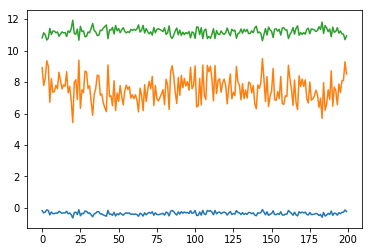

AE2 mse =  0.00784537423425


In [6]:
# https://stackoverflow.com/a/43549608/4126114
#tensorboard = keras.callbacks.TensorBoard(log_dir='/tmp/tb/r0-AE-15-3-nonsymmetric',
#                 histogram_freq=10, 
#                 write_graph=True, 
#                 write_images=False)

deep_ae, deep_enc = utils.buildNetwork2_deep(X.shape[1], enc_dim1 = n_c_i, enc_dim2 = 3, symmetric=False)
deep_ae.summary()
X_rec = utils.ae_fit_encode_plot_mse(X, deep_ae, deep_enc, N_epochs, verbose=2)#, callbacks=[tensorboard])
print("AE2 mse = ", utils.mse(X, X_rec))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 15)                45        
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 48        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 15)                60        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 32        
Total para

/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1977: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


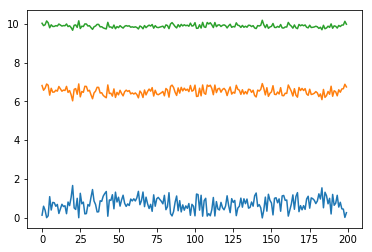

AE2 mse =  0.0118928231991


In [7]:
# https://stackoverflow.com/a/43549608/4126114
#tensorboard = keras.callbacks.TensorBoard(log_dir='/tmp/tb/r0-AE-15-3-nonsymmetric',
#                 histogram_freq=10, 
#                 write_graph=True, 
#                 write_images=False)

deep_ae, deep_enc = utils.buildNetwork2_deep(X.shape[1], enc_dim1 = n_c_i, enc_dim2 = 3, symmetric=True)
deep_ae.summary()
X_rec = utils.ae_fit_encode_plot_mse(X, deep_ae, deep_enc, N_epochs, verbose=0)#, callbacks=[tensorboard])
print("AE2 mse = ", utils.mse(X, X_rec))

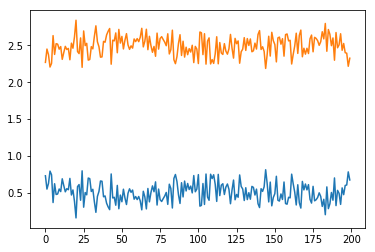

In [8]:
utils.myPlot(X,2)

## LSTM-based autoencoder

In [7]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM
from keras.layers import RepeatVector, TimeDistributed, Input
from keras.layers.advanced_activations import LeakyReLU #, PReLU

in_neurons = X.shape[1]
print(in_neurons)
out_neurons = in_neurons
hidden_neurons = 25
# set below by judging by the crescents of the sin and cos in data generation
# look back = 50 with hidden neurons = 25 => MSE = 0.008
# look back = 100 with hidden neurons = 25 => MSE = 0.05
# ditty with enc_dim = 3 => MSE = ?
# BUT PERHAPS MEASURING WITH MSE LIKE THIS IS NOT GOOD
# BECAUSE I SEE THAT THE PREDICTED SIGNAL IS LAGGED
# I PROBABLY NEED SOME ALIGNMENT BEFORE CALCULATING MSE
look_back = 100 # FIXME
enc_dim = None #3 # FIXME None

autoencoder = Sequential()

# autoencoder.add(Input(shape=(look_back, in_neurons))

# combined from Simple_LSTM_keras_2 and LSTM book, chap 9, seq2seq
autoencoder.add(LSTM(hidden_neurons, return_sequences=False, input_shape=(None, in_neurons)))

# encoder layer
if enc_dim is not None:
    autoencoder.add(Dense(enc_dim, activation='linear'))
    autoencoder.add(LeakyReLU(alpha=.3))

autoencoder.add(RepeatVector(look_back))
autoencoder.add(LSTM(hidden_neurons, return_sequences=True))
autoencoder.add(TimeDistributed(Dense(out_neurons, activation='linear')))

autoencoder.compile(loss="mean_squared_error", optimizer="rmsprop")

autoencoder.summary()


2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                2800      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 25)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 25)           5100      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 2)            52        
Total params: 7,952
Trainable params: 7,952
Non-trainable params: 0
_________________________________________________________________
----------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1_input (InputLayer)    (None, None, 2)           0         
_____________________________________________________________

(10000, 2) (8901, 100, 2) (901, 100, 2)


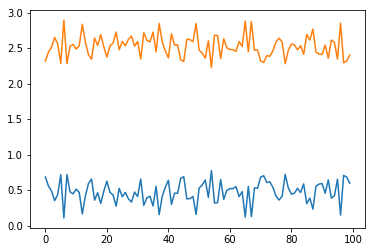

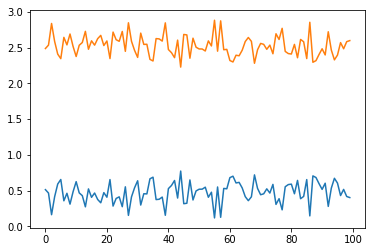

In [8]:
from utils2 import train_test_split
(X_train), (X_test) = train_test_split(X)  # retrieve data
print(X.shape, X_train.shape, X_test.shape)

#x2 = [100+x for x in range(len(y_test))]
#print(len(x2),x2)

utils.myPlot(X_test[0],2)
utils.myPlot(X_test[10],2)

In [9]:
# https://stackoverflow.com/a/43549608/4126114
tensorboard = keras.callbacks.TensorBoard(log_dir='/tmp/tb/r2-lstm-25',
                 histogram_freq=10, 
                 write_graph=True, 
                 write_images=False)


epochs=200 # FIXME # 10
print(X_train.shape)
autoencoder.fit(X_train, X_train, batch_size=450, epochs=epochs, validation_split=0.05, callbacks=[tensorboard])

(8901, 100, 2)
Train on 8455 samples, validate on 446 samples
INFO:tensorflow:Summary name lstm_1/kernel:0 is illegal; using lstm_1/kernel_0 instead.
INFO:tensorflow:Summary name lstm_1/recurrent_kernel:0 is illegal; using lstm_1/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_1/bias:0 is illegal; using lstm_1/bias_0 instead.
INFO:tensorflow:Summary name lstm_2/kernel:0 is illegal; using lstm_2/kernel_0 instead.
INFO:tensorflow:Summary name lstm_2/recurrent_kernel:0 is illegal; using lstm_2/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_2/bias:0 is illegal; using lstm_2/bias_0 instead.
INFO:tensorflow:Summary name time_distributed_1/kernel:0 is illegal; using time_distributed_1/kernel_0 instead.
INFO:tensorflow:Summary name time_distributed_1/bias:0 is illegal; using time_distributed_1/bias_0 instead.
Epoch 1/200
8455/8455 [==============================] - 9s - loss: 0.0655 - val_loss: 0.0217
Epoch 2/200
8455/8455 [==============================] - 8s - lo

KeyboardInterrupt: 

1 (901, 100, 2) (901, 100, 2) 0.260165778995


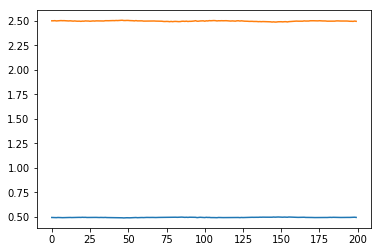

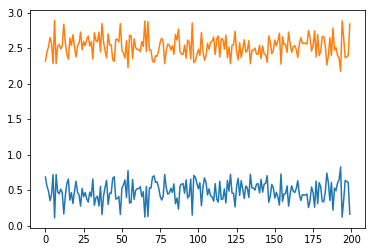

In [10]:
predicted = autoencoder.predict(X_test)  
rmse = utils.mse(X_test[:,0,:], predicted[:,0,:])
print(1, X_test.shape, predicted.shape, rmse)

#utils.myPlot(predicted[:,0,:],2)
#utils.myPlot(X_test[:,0,:],2)
utils.myPlot(predicted[:,0,:],2)
utils.myPlot(X_test[:,0,:],2)

In [11]:
print('-'*10)
from keras.models import Model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)
encoder.compile(loss="mean_squared_error", optimizer="rmsprop")
encoder.summary()

X_enc = encoder.predict(X_test)

----------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1_input (InputLayer)    (None, None, 2)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                2800      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 25)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 25)           5100      
Total params: 7,900
Trainable params: 7,900
Non-trainable params: 0
_________________________________________________________________


(901, 100, 2) (901, 100, 25)


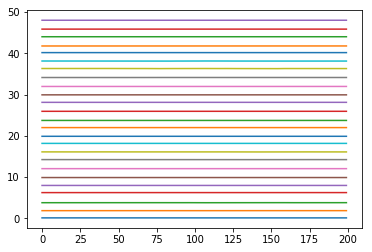

In [12]:
print(X_test.shape, X_enc.shape)
utils.myPlot(X_enc[:,0,:],2) # should not need utils.myNorm3